(3, 192, 192, 3)
0 255
(3, 6, 192, 192)
0.0 1.0


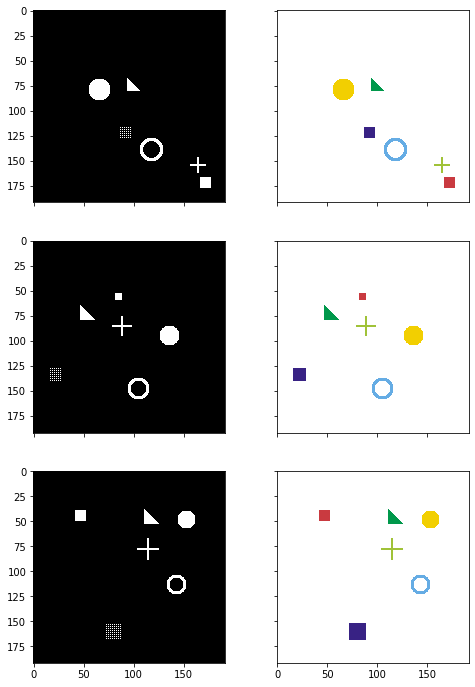

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import helper
import simulation

# Generate some random images
input_images, target_masks = simulation.generate_random_data(192, 192, count=3)

for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]

# Left: Input image, Right: Target mask (Ground-truth)
helper.plot_side_by_side([input_images_rgb, target_masks_rgb])

In [10]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [12]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)  
        self.input_images = rgb2gray(self.input_images)
        print(self.input_images.shape)
        self.transform = transform
    
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
        
        return [image, mask]

# use same transform for train/val for this example
trans = transforms.Compose([
    transforms.ToTensor(),
])

train_set = SimDataset(2000, transform = trans)
val_set = SimDataset(200, transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

(2000, 192, 192)
(200, 192, 192)


{'train': 2000, 'val': 200}

torch.Size([25, 1, 192, 192]) torch.Size([25, 6, 192, 192])
0.0 254.97449999999998 6.191210244140628 39.24626927629532
0.0 1.0 0.004873951 0.0696435


TypeError: Invalid shape (192, 192, 1) for image data

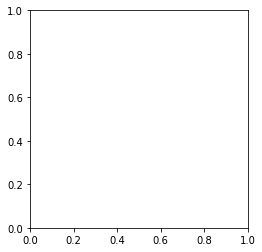

In [13]:
import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(inputs[3]))

In [5]:
from torchsummary import summary
import torch
import torch.nn as nn
import pytorch_unet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = pytorch_unet.UNet(6)
model = model.to(device)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [14]:
from torchsummary import summary
import torch
import torch.nn as nn
import pytorch_unet

In [17]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                #for param_group in optimizer.param_groups:
                #    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device,dtype=torch.float)
                labels = labels.to(device,dtype=torch.float)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)
                
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
            

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 6

model = pytorch_unet.UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=80)

cuda:0
Epoch 0/79
----------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


LR 0.0001
train: bce: 0.168240, dice: 0.717478, loss: 0.442859
val: bce: 0.016751, dice: 0.406796, loss: 0.211773
saving best model
0m 23s
Epoch 1/79
----------
LR 0.0001
train: bce: 0.011461, dice: 0.310499, loss: 0.160980
val: bce: 0.005574, dice: 0.228115, loss: 0.116845
saving best model
0m 23s
Epoch 2/79
----------
LR 0.0001
train: bce: 0.003425, dice: 0.106782, loss: 0.055104
val: bce: 0.003042, dice: 0.064548, loss: 0.033795
saving best model
0m 24s
Epoch 3/79
----------
LR 0.0001
train: bce: 0.002458, dice: 0.048625, loss: 0.025541
val: bce: 0.002458, dice: 0.048747, loss: 0.025602
saving best model
0m 24s
Epoch 4/79
----------
LR 0.0001
train: bce: 0.002315, dice: 0.043248, loss: 0.022782
val: bce: 0.002111, dice: 0.036049, loss: 0.019080
saving best model
0m 24s
Epoch 5/79
----------
LR 0.0001
train: bce: 0.002029, dice: 0.037389, loss: 0.019709
val: bce: 0.001967, dice: 0.035440, loss: 0.018704
saving best model
0m 24s
Epoch 6/79
----------
LR 0.0001
train: bce: 0.001834, di

val: bce: 0.000759, dice: 0.016025, loss: 0.008392
saving best model
0m 25s
Epoch 53/79
----------
LR 1.0000000000000002e-06
train: bce: 0.000659, dice: 0.014821, loss: 0.007740
val: bce: 0.000753, dice: 0.015956, loss: 0.008354
saving best model
0m 25s
Epoch 54/79
----------
LR 1.0000000000000002e-06
train: bce: 0.000657, dice: 0.014790, loss: 0.007723
val: bce: 0.000754, dice: 0.016011, loss: 0.008382
0m 25s
Epoch 55/79
----------
LR 1.0000000000000002e-06
train: bce: 0.000652, dice: 0.014773, loss: 0.007713
val: bce: 0.000749, dice: 0.015892, loss: 0.008320
saving best model
0m 25s
Epoch 56/79
----------
LR 1.0000000000000002e-06
train: bce: 0.000648, dice: 0.014733, loss: 0.007691
val: bce: 0.000734, dice: 0.015796, loss: 0.008265
saving best model
0m 25s
Epoch 57/79
----------
LR 1.0000000000000002e-06
train: bce: 0.000645, dice: 0.014689, loss: 0.007667
val: bce: 0.000741, dice: 0.015804, loss: 0.008272
0m 25s
Epoch 58/79
----------
LR 1.0000000000000002e-06
train: bce: 0.000642,

In [20]:
torch.save(model,"pretrained_model.ckpt")

In [21]:
torch.save(model.state_dict(),"pretrained_model_satet_dict.ckpt")

(3, 6, 192, 192)


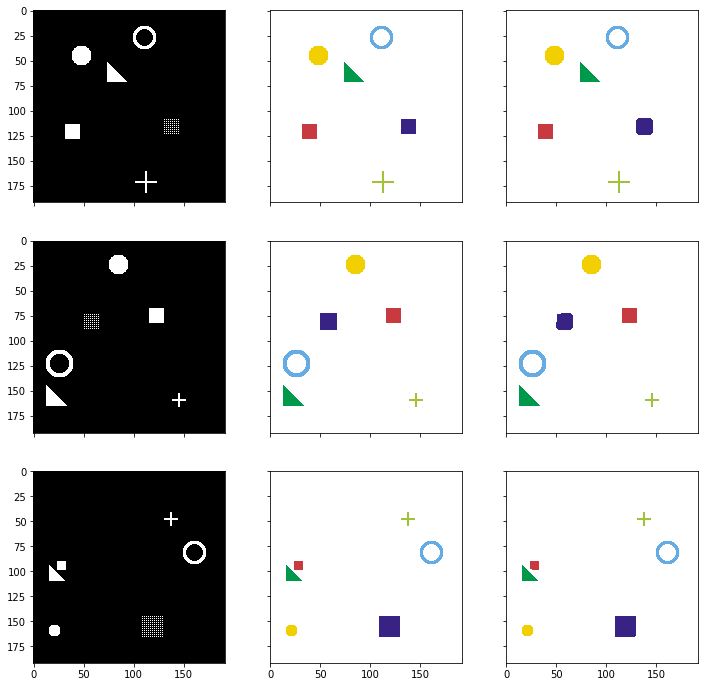

In [12]:
# prediction

import math

model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [11]:
files = os.listdir("./INSAT3D_VIS_India")

In [13]:
files.sort()
files[8:25]

['3DIMG_07NOV2019_0400_L1C_SGP_vis.tif',
 '3DIMG_07NOV2019_0430_L1C_SGP_vis.tif',
 '3DIMG_07NOV2019_0500_L1C_SGP_vis.tif',
 '3DIMG_07NOV2019_0530_L1C_SGP_vis.tif',
 '3DIMG_07NOV2019_0600_L1C_SGP_vis.tif',
 '3DIMG_07NOV2019_0630_L1C_SGP_vis.tif',
 '3DIMG_07NOV2019_0700_L1C_SGP_vis.tif',
 '3DIMG_07NOV2019_0730_L1C_SGP_vis.tif',
 '3DIMG_07NOV2019_0800_L1C_SGP_vis.tif',
 '3DIMG_07NOV2019_0830_L1C_SGP_vis.tif',
 '3DIMG_07NOV2019_0859_L1C_SGP_vis.tif',
 '3DIMG_07NOV2019_0900_L1C_SGP_vis.tif',
 '3DIMG_07NOV2019_0929_L1C_SGP_vis.tif',
 '3DIMG_07NOV2019_0930_L1C_SGP_vis.tif',
 '3DIMG_07NOV2019_0959_L1C_SGP_vis.tif',
 '3DIMG_07NOV2019_1000_L1C_SGP_vis.tif',
 '3DIMG_07NOV2019_1030_L1C_SGP_vis.tif']